# Prototyping Models w/ PyTorch

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.datasets
import sklearn.linear_model
import torch
from torch.nn import Sequential, Linear, ReLU, MSELoss

import pytest
import ipytest
import ipytest.magics

from chmp.torch_util import (
    TorchModel, 
    linear, 
    WeightsHS,
    LossHistory,
    NllLoss,
    NormalModelConstantScale, 
    KLDivergence,
    Transformer,
    SimpleBayesTorchModel,
    iter_batch_indices,
)

ipytest.config.rewrite_asserts = True
__file__ = 'tech_TorchModels.ipynb'

In [2]:
# create a regression data set
x, y = sklearn.datasets.make_regression(
    n_samples=1_000, 
    n_features=10, 
    n_informative=2, 
    shuffle=False, 
    random_state=42_42_42,
)

# with redudant features
x = np.concatenate([x, x], axis=1)

# and redudant samples
x = np.concatenate([x, x], axis=0)
y = np.concatenate([y, y], axis=0)

In [3]:
print(x.shape)

(2000, 20)


In [4]:
class LinearHS(NormalModelConstantScale):
    def __init__(self, in_features, out_features, tau_0, bias=True):
        super().__init__()
        
        self.weights = WeightsHS((in_features, out_features), tau_0=tau_0)
        self.bias = torch.nn.Parameter(torch.zeros(1)) if bias else 0
        
    def transform(self, x):
        return self.bias + linear(x, self.weights())
    
    def kl_divergence(self):
        return self.weights.kl_divergence()

In [5]:
n_samples, n_features = x.shape

## Linear regression model with horeshoe prior

See C. Louizos, K. Ullrich, and M. Welling, "[Bayesian Compression for Deep Learning](https://arxiv.org/abs/1705.08665)" (2017).

Use Horseshoe prior on the weights:

$$
\begin{align}
    s_a \sim &\mathcal{G}(0, \tau_0^2) \\
    s_b^{-1} &\sim \mathcal{G}(0, 1/2) \\
    \alpha_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \beta^{-1}_{ij} &\sim \mathcal{G}(0, 1/2) \\
    \tilde{w}_{ij} &\sim \mathcal{N}(0, 1) \\
    w_{ij} &= \tilde{w}_{ij} \sqrt{s_a / s_b} \sqrt{\alpha / \beta}
\end{align}
$$

Use the variational approximation:
$$
\begin{align}
    q(s_a) &= \mathcal{LN}(\dots) \\
    q(s_b^{-1}) &= \mathcal{LN}(\dots) \\
    q(\alpha_{ij}) &= \mathcal{LN}(\dots) \\
    q(\beta_{ij}^-{1}) &= \mathcal{LN}(\dots) \\
    q(\tilde{w}_{ij}) &= \mathcal{N}(\dots) \\
\end{align}
$$

In [6]:
model = SimpleBayesTorchModel(
    module=LinearHS(n_features, 1, tau_0=1e-5),
    n_observations=n_samples,
    optimizer_kwargs=dict(lr=1e-2),
)

loss_history = LossHistory()
model.fit(x, y, epochs=1_000, verbose=True, callbacks=[loss_history])

[done. took 4m 39s] 1.27 (epoch 999 / 1,000)                                                                            



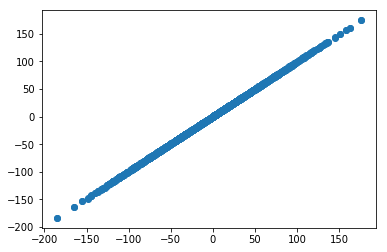

In [7]:
y_pred_loc, y_pred_scale = model.predict(x.astype('float32'))
plt.scatter(y, y_pred_loc)

/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
/Volumes/Home/.local/share/virtualenvs/misc-exp-8XcdncOT/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


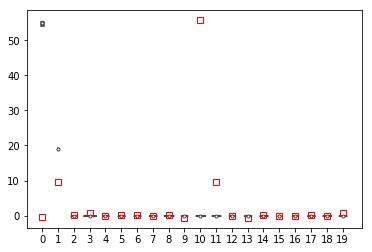

In [8]:
linear_coefs = sklearn.linear_model.LinearRegression().fit(x, y).coef_
weights = np.concatenate([model.module.weights().detach().numpy() for _ in range(100)], axis=1)

sns.violinplot(data=weights.T)
plt.plot(linear_coefs, 's', markeredgecolor='r', markerfacecolor='none')

## Attention

Use an attention model of the form

$$
\begin{align}
    \alpha_{ij} &= q(x_i)^T k(x_j) \\
    p_{ij} &= \mathrm{softmax}(\alpha_{ij}, \mathrm{mask}) \\
    \hat{y}_i &= \sum_j p_{ij} v(x_j, y_j)
\end{align}
$$

In [9]:
batch_size = 20

def transformer_fit_data():
    for _ in range(100):
        yield from transformer_batch_data(include_target=True, shuffle=True)
            
            
def transformer_batch_data(include_target=True, shuffle=True):
    for batch_indices in iter_batch_indices(len(x), batch_size=batch_size, shuffle=shuffle):
        mask = np.ones((len(batch_indices), len(x)))
        mask[np.arange(len(batch_indices)), batch_indices] = 0

        np.testing.assert_allclose(np.sum(mask, axis=1), (len(x) - 1))

        batch_x = {
            'search_x': x.astype('float32'),
            'search_y': y.astype('float32'),
            'query_x': x[batch_indices].astype('float32'),
            'mask': mask
        }
        
        if include_target:
            batch_y = y[batch_indices].astype('float32')
            yield batch_x, batch_y
        
        else:
            yield batch_x
            
            
module = Transformer(
    key_module=torch.nn.Sequential(
        Linear(n_features, 20),
        ReLU(),
        Linear(20, 20),
        ReLU(),
    ),
)
model = TorchModel(
    module=module,
    loss=MSELoss(),
    optimizer=lambda parameters: torch.optim.Adam(parameters, lr=1e-2),
)

model.fit_generator(transformer_fit_data(), steps_per_epoch=len(x) // batch_size, epochs=100, dtype=None)

[done. took 2m 53s] 10.3 (epoch 99 / 100)                                                                               



[/ 0.52s / ?] predict                                                                                                   



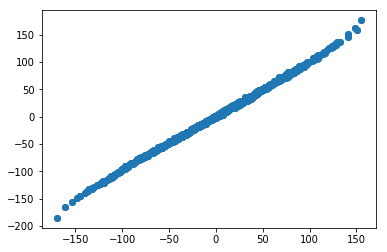

In [10]:
y_pred = model.predict_generator(transformer_batch_data(include_target=False, shuffle=False), dtype=None)
plt.scatter(y_pred, y)